# CS-6570 Assignment 3 - Variable Selection

*Weber State University*

Rob Christiansen


For this assignment we're going to build and attempt to optimize regression models using some of the techniques we're learned so far in class.

First, let's import our favorite libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

There are also some libraries and functions we'll need for creating and testing our models:

In [2]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error

The dataset we'll use for this is the "Hitters" dataset ("Hitters.csv"), which is a dataset of Major League Baseball player statistics from 1986-1987. More info about the dataset can be found [here](https://www.kaggle.com/datasets/floser/hitters).

In [3]:
df_hitters = pd.read_csv('Datasets/Hitters.csv')
df_hitters.head()

,Unnamed: 0,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,...,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,-Andy Allanson,293,66,1,30,29,14,1,293,66,...,30,29,14,A,E,446,33,20,NaN,A
1,-Alan Ashby,315,81,7,24,38,39,14,3449,835,...,321,414,375,N,W,632,43,10,475.0,N
2,-Alvin Davis,479,130,18,66,72,76,3,1624,457,...,224,266,263,A,W,880,82,14,480.0,A
3,-Andre Dawson,496,141,20,65,78,37,11,5628,1575,...,828,838,354,N,E,200,11,3,500.0,N
4,-Andres Galarraga,321,87,10,39,42,30,2,396,101,...,48,46,33,N,E,805,40,4,91.5,N


Let's rename that first column.

In [4]:
df_hitters.rename(columns={"Unnamed: 0": "Player"}, inplace=True) #Name the first column "Player"

Note that the Salary variable is missing for some of the players. The isnull() function can be used to identify the missing observations. It returns a vector of the same length as the input vector, with a TRUE value for any elements that are missing, and a FALSE value for non-missing elements. The sum() function can then be used to count all of the missing elements:

In [5]:
print("Number of null values:", df_hitters["Salary"].isnull().sum())

Number of null values: 59


We see that Salary is missing for 59 players. That's not too many. Let's drop them. The dropna() function removes all of the rows that have missing values in any variable:

In [6]:
# Print the dimensions of the original Hitters data (322 rows x 20 columns)
print("Dimensions of original data:", df_hitters.shape)

# Drop any rows the contain missing values, along with the player names
df_hitters_clean = df_hitters.dropna()

# Print the dimensions of the modified Hitters data (263 rows x 20 columns)
print("Dimensions of modified data:", df_hitters_clean.shape)

# One last check: should return 0
print("Number of null values:", df_hitters_clean["Salary"].isnull().sum())

Dimensions of original data: (322, 21)
Dimensions of modified data: (263, 21)
Number of null values: 0


Alright, so we've now dropped all the rows with missing data.

Some of our predictors are categorical, so for this exercise we'll eliminate those. We'll also specify the variable, "Salary", that we're trying to predict.

In [7]:
#Create the response variable.
y = df_hitters_clean.Salary

# Drop the column with the independent variable (Salary), and the columns with categorical data
#The axis=1 parameter specifies we're dropping columns, and not rows.
#The .astype('float64') casts all remaining data as floats.
X = df_hitters_clean.drop(['Salary', 'League', 'Division', 'NewLeague', 'Player'], axis=1)
X

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,632,43,10
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,880,82,14
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,200,11,3
4,321,87,10,39,42,30,2,396,101,12,48,46,33,805,40,4
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,282,421,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,497,127,7,65,48,37,5,2703,806,32,379,311,138,325,9,3
318,492,136,5,76,50,94,12,5511,1511,39,897,451,875,313,381,20
319,475,126,3,61,43,52,6,1700,433,7,217,93,146,37,113,7
320,573,144,9,85,60,78,8,3198,857,97,470,420,332,1314,131,12


Now, for this assignment we're going to create a subset that will be our training data, and a subset that will be our test data. Let's do an 80/20 split:

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2,random_state = 42)

## Backward Subset Selection ##

If we build a linear model with all these inputs, we'll likely overfit the model. To avoid this, we'd like to build a model using only the most important variables. But, which subset of variables is most important?

In lecture 9, we learned three methods for selecting the best subset of variables for a linear model:

* Best subset selection
* Forward stepwise selection
* Backward stepwised selection

We went over algorithms for each of these, and implemented two (best subset and forward stepwise) as Python code. In this assignment, you'll implement backward stepwise selection.

The basic algorithm for backward stepwise selection is:

_Algorithm_

- Let $M_{p}$ denote the full model which contains all $p$ predictors.

- For $k=p,p-1,...,1$
    - Consider all $k$ models that contain all but one of the predictors in $M_{k}$, for a total of $k-1$ predictors.
    - Pick the best among these $k$ models, and call in $M_{k-1}$. Here can define _best_ as having the smallest $RSS$ or highest $R^{2}$
- Select the single best model among $M_{0},M_{1},...,M_{n}$ using $C_{p}$, $BIC$, adjusted $R^{2}$ or any other method.

For this assignment, use the largest $R^{2}$ to determine the best model at each step, and select the overall best model using the adjusted $R^{2}$.

We'll start out with a list of all the predictors:

In [9]:
backwards_features = list(X.columns)
p = len(backwards_features)

In [10]:
backwards_features

['AtBat',
 'Hits',
 'HmRun',
 'Runs',
 'RBI',
 'Walks',
 'Years',
 'CAtBat',
 'CHits',
 'CHmRun',
 'CRuns',
 'CRBI',
 'CWalks',
 'PutOuts',
 'Assists',
 'Errors']

We'll also create two empty lists that you should fill:
* *R2_list_backwards* - Fill this with the best $R^{2}$ value that you find at each step.
* *features_list_backwards* - Fill this with the best set of features that you find at each step.
* *R2_test_list_backwards* - Fill this with the performance of the model on the test data using the best set of features found at each step.

In [11]:
R2_list_backwards, features_list_backwards, R2_test_list_backwards = [], [], []

Alright, now it's time for you to write your own code! Write code that appropriately populates the two lists just created. However, do so using just the *X_train* and *y_train* datasets.

In [12]:
def fit_linear_reg(X,Y):
    #Fit linear regression model and return RSS and R squared values
    model_k = linear_model.LinearRegression()
    model_k.fit(X,Y)
    RSS = mean_squared_error(Y,model_k.predict(X)) * len(Y)
    R_squared = model_k.score(X,Y)
    return RSS, R_squared

In [13]:
# Search for best combinations

# import itertools
# from sklearn.metrics import mean_squared_error

# RSS_list_backwards, features_list_backwards, R2_test_list_backwards = [], [], []
# numb_features = []

# #Looping over the features in X
# for k in range(1,len(X_train.columns) + 1):
#     #Looping over all possible combinations: from 9 choose k
#     for combo in itertools.combinations(X_train.columns,k):
#         tmp_result = fit_linear_reg(X_train[list(combo)],y_train)                   #Store temp result 
#         RSS_list_backwards.append(tmp_result[0])                                    #Append lists
#         R2_test_list_backwards.append(tmp_result[1])
#         features_list_backwards.append(combo)
#         numb_features.append(len(combo))   

# #Store in DataFrame
# df = pd.DataFrame({'numb_features': numb_features,'RSS': RSS_list_backwards, 'R_squared':R2_test_list_backwards,'features':features_list_backwards})

In [14]:
RSS_list_backwards, R2_list_backwards, features_list_backwards, R2_test_list_backwards, features_list_count = [], [], [], [], []

In [15]:
import itertools

# Forward Stepwise from Lecture

X = X_train
Y = y_train

remaining_features = list(X.columns.values)
features = []
RSS_list, R_squared_list = [np.inf], [np.inf] #Due to 1 indexing of the loop...
features_list = dict()

for i in range(len(X.columns)+1,1,-1): # Changed this to go backwards and change the step value to -1
    print(f"i: {i}")
    best_RSS = np.inf                   # Reset to float
    best_feature = str
    
    for combo in itertools.combinations(remaining_features,1):

            RSS = fit_linear_reg(X[list(combo) + remaining_features],Y)   #Store temp result 

            if RSS[0] < best_RSS:           # RSS is a cost function so small numbers are good. Swapped the direction of the arrow
                best_RSS = RSS[0]
                best_R_squared = RSS[1] 
                best_feature = combo[0]
                best_feature_count = combo
                test_RSS = fit_linear_reg(X_test[list(combo) + features],y_test)   # Run the test set R2 during processing
                best_R_squared_test = test_RSS[1]

    #Updating variables for next loop
    features.append(best_feature)
    remaining_features.remove(best_feature)
    
    # Set desired variables
    RSS_list.append(best_RSS)
    R2_list_backwards.append(best_R_squared)
    R2_test_list_backwards.append(best_R_squared_test)
    features_list[i] = remaining_features.copy()    # This is the important row to put into the dataframe
    features_list_count.append(i)
    features_list_backwards.append(features_list)

i: 17
i: 16
i: 15
i: 14
i: 13
i: 12
i: 11
i: 10
i: 9
i: 8
i: 7
i: 6
i: 5
i: 4
i: 3
i: 2


In [16]:
print(f'features_list_backwards :{len(features_list_backwards)}')
print(f'R2_list_backwards :{len(R2_list_backwards)}')
print(f'features_list_count :{len(features_list_count)}')
print(f'R2_test_list_backwards :{len(R2_test_list_backwards)}')

features_list_backwards :16
R2_list_backwards :16
features_list_count :16
R2_test_list_backwards :16


In [17]:
print('Backward stepwise subset selection')
print('Number of features |', 'Features |', 'RSS')
display([(i,features_list_backwards[i], round(RSS_list[i])) for i in range(1,5)])

Backward stepwise subset selection
Number of features | Features | RSS


[(1,
  {17: ['AtBat',
    'Hits',
    'HmRun',
    'Runs',
    'RBI',
    'Walks',
    'Years',
    'CAtBat',
    'CHits',
    'CHmRun',
    'CRuns',
    'CWalks',
    'PutOuts',
    'Assists',
    'Errors'],
   16: ['AtBat',
    'Hits',
    'HmRun',
    'Runs',
    'RBI',
    'Walks',
    'Years',
    'CAtBat',
    'CHits',
    'CRuns',
    'CWalks',
    'PutOuts',
    'Assists',
    'Errors'],
   15: ['AtBat',
    'Hits',
    'HmRun',
    'Runs',
    'RBI',
    'Walks',
    'Years',
    'CAtBat',
    'CHits',
    'CWalks',
    'PutOuts',
    'Assists',
    'Errors'],
   14: ['AtBat',
    'HmRun',
    'Runs',
    'RBI',
    'Walks',
    'Years',
    'CAtBat',
    'CHits',
    'CWalks',
    'PutOuts',
    'Assists',
    'Errors'],
   13: ['HmRun',
    'Runs',
    'RBI',
    'Walks',
    'Years',
    'CAtBat',
    'CHits',
    'CWalks',
    'PutOuts',
    'Assists',
    'Errors'],
   12: ['Runs',
    'RBI',
    'Walks',
    'Years',
    'CAtBat',
    'CHits',
    'CWalks',
    'PutOuts'

Next, create a dataframe with four columns: the feature list, $R^{2}$ values, and test $R^{2}$ values lists you just created, plus another column that records the number of features.

In [18]:
features_list_backwards

[{17: ['AtBat',
   'Hits',
   'HmRun',
   'Runs',
   'RBI',
   'Walks',
   'Years',
   'CAtBat',
   'CHits',
   'CHmRun',
   'CRuns',
   'CWalks',
   'PutOuts',
   'Assists',
   'Errors'],
  16: ['AtBat',
   'Hits',
   'HmRun',
   'Runs',
   'RBI',
   'Walks',
   'Years',
   'CAtBat',
   'CHits',
   'CRuns',
   'CWalks',
   'PutOuts',
   'Assists',
   'Errors'],
  15: ['AtBat',
   'Hits',
   'HmRun',
   'Runs',
   'RBI',
   'Walks',
   'Years',
   'CAtBat',
   'CHits',
   'CWalks',
   'PutOuts',
   'Assists',
   'Errors'],
  14: ['AtBat',
   'HmRun',
   'Runs',
   'RBI',
   'Walks',
   'Years',
   'CAtBat',
   'CHits',
   'CWalks',
   'PutOuts',
   'Assists',
   'Errors'],
  13: ['HmRun',
   'Runs',
   'RBI',
   'Walks',
   'Years',
   'CAtBat',
   'CHits',
   'CWalks',
   'PutOuts',
   'Assists',
   'Errors'],
  12: ['Runs',
   'RBI',
   'Walks',
   'Years',
   'CAtBat',
   'CHits',
   'CWalks',
   'PutOuts',
   'Assists',
   'Errors'],
  11: ['Runs',
   'RBI',
   'Walks',
   'Years',

In [19]:
#TODO: Create a dataframe consisting of the feature list, the R^2 values, and the number of features for each submodel $M_{i}$.

df_summary = pd.DataFrame()
# features_list_backwards_series = pd.Series(features_list_backwards)

df_summary.insert(loc=0, column='Features', value=features_list_backwards, allow_duplicates=True)
df_summary.insert(loc=1, column='R^2', value=R2_list_backwards, allow_duplicates=True)
df_summary.insert(loc=2, column='Features Count', value=features_list_count, allow_duplicates=True)
df_summary.insert(loc=3, column='Test R^2', value=R2_test_list_backwards, allow_duplicates=True)

Finally, plot the adjusted $R^{2}$ values for each set of predictor variables, with the number of predictor variables on the $x$-axis. Mark the maximum, and print the predictors associated with that maximum.

Recall that the adjusted $R^{2}$ is defined as:

$\displaystyle R^{2}_{a} = 1-\frac{RSS/(n-k-1)}{TSS/n-1}$


More importantly, we need to calculate the adjusted R^2 from R^2:
![Alt text](image.png)
Source: https://stackoverflow.com/questions/49381661/how-do-i-calculate-the-adjusted-r-squared-score-using-scikit-learn
&nbsp;

In [20]:
df_summary

,Features,R^2,Features Count,Test R^2
0,"{17: ['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI',...",0.571629,17,0.174878
1,"{17: ['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI',...",0.567224,16,0.177620
2,"{17: ['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI',...",0.555124,15,0.219607
3,"{17: ['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI',...",0.541500,14,0.230772
4,"{17: ['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI',...",0.527903,13,0.286478
5,"{17: ['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI',...",0.527248,12,0.297924
6,"{17: ['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI',...",0.527218,11,0.305751
7,"{17: ['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI',...",0.525506,10,0.306777
8,"{17: ['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI',...",0.525412,9,0.308772
9,"{17: ['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI',...",0.521482,8,0.389082


max_adjusted_R2: 0.5337008260314421 at position: 0


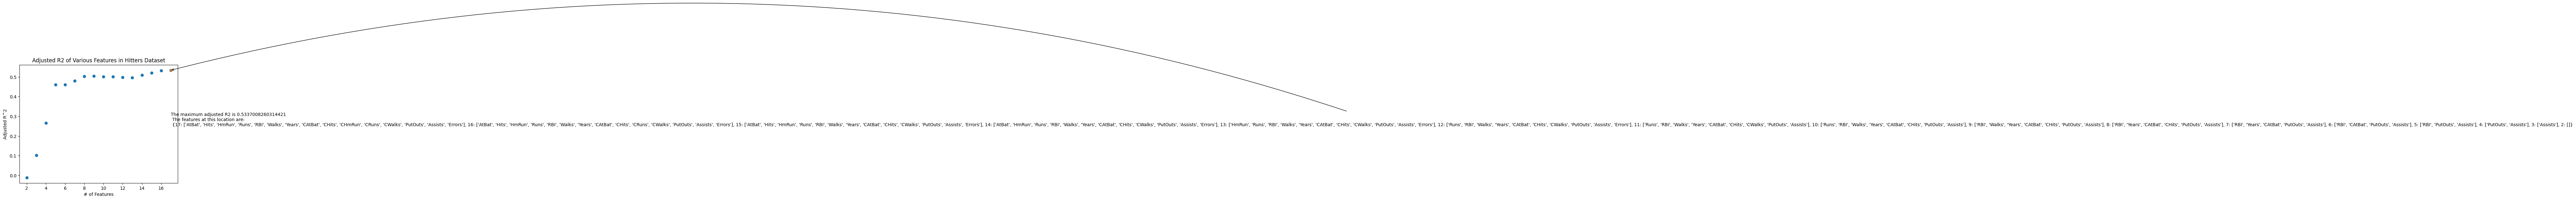

In [21]:
# TODO: Plot the adjusted R^2 values for the number of predictor variables, mark the maximum, and print the predictors associated with that maximum.

adjusted_R2 = []
adjusted_R2 = 1 - (1 - np.array(R2_list_backwards)) * ((len(X_train)-1)/(len(X_train)-np.array(features_list_count)-1))
df_summary.insert(loc=4, column='Adjusted R^2', value=adjusted_R2, allow_duplicates=True)

# Determine the max adjusted R^2
max_adjusted_R2 = adjusted_R2.max()
max_adjusted_R2_index = (np.where(adjusted_R2 == max_adjusted_R2)) # Convert from np array to list
# for item in max_adjusted_R2_index:
max_adjusted_R2_index_int = max_adjusted_R2_index[0][0] #Need to improve to deal with the case when the max is shared by multiple values (long shot)

print(f"max_adjusted_R2: {max_adjusted_R2} at position: {max_adjusted_R2_index_int}")

## PLOT THE VALUES
fig, ax = plt.subplots()

ax.scatter(features_list_count, adjusted_R2)
ax.scatter(features_list_count[max_adjusted_R2_index_int],adjusted_R2[max_adjusted_R2_index_int], marker='*')

ax.set_title('Adjusted R2 of Various Features in Hitters Dataset')
ax.set_xlabel('# of Features')
ax.set_ylabel('Adjusted R^2')
# ax.annotate("The maximum R^2 is here", xy=(1890, .065), color='gray', horizontalalignment='left',fontsize=8)

ax.annotate(f"The maximum adjusted R2 is {max_adjusted_R2}\n The features at this location are:\n {features_list_backwards[max_adjusted_R2_index_int]}",
        xy = (features_list_count[max_adjusted_R2_index_int],adjusted_R2[max_adjusted_R2_index_int]),
        xytext = (17,0.25),
        arrowprops=dict(arrowstyle='->',
                        connectionstyle='arc3, rad=0.15'))

plt.show()

Alright! Now, let's check if the number of predictors we determined using the adjusted $R^{2}$ value actually does the best on our test data.

To do this, plot the actual $R^{2}$ value for each set of predictor variables when run on the test data. Again, make the x-axis the number of predictors, mark the maximum, and print the predictors associated with that maximum.

In [22]:
# Reset the variables
R2_list_backwards_test, features_list_backwards_test, R2_test_list_backwards_test = [], [], []

# TODO: Plot the R^2 values for the given number of predictor variables when the model is run on the test data. Mark the maximum, and print the predictors associated with that maximum.

regression_score = float
predictions_test, features_list_count_test = [], []

for n in range(len_backwards_features):
    X = X_test[backwards_features[0:len_backwards_features-n]].to_numpy() 
    # print(f"X is {X}")
    print(f"X.shape: {X.shape}")
    print(f"y_test.shape: {y_test.shape}")
    # regr.fit(X,y_test)                                                   # The model has already been trained, but in this instance I think we want to retrain it
    predictions_test = regr.predict(X)
    regression_score = regr.score(X,y_test).astype(float) # Want to avoid scoring the regression multiple times
    print("For predictors {} \n the r-squared value is {}\n".format(backwards_features[0:len_backwards_features-n],regr.score(X,y_test)))
    features_list_backwards_test.append(str(backwards_features[0:len_backwards_features-n]))
    R2_list_backwards_test.append(regression_score)
    features_list_count_test.append(len_backwards_features-n)


NameError: name 'len_backwards_features' is not defined

Now, plot both on the same line charts on the same figure.

In [ ]:
# TODO: Plot both line charts on the same figure.

In [ ]:
# TODO: Plot the adjusted R^2 values for the number of predictor variables, mark the maximum, and print the predictors associated with that maximum.

adjusted_R2_test = []
adjusted_R2_test = 1 - (1 - np.array(R2_list_backwards_test)) * ((len(X_train)-1)/(len(X_train)-np.array(features_list_count)-1))
# adjusted_R2 = 1 - (1 - np.array(R2_list_backwards)**2)*(len(X_train)-1/(len(X_train)-np.array(features_list_count)-1))
df_summary.insert(loc=4, column='Adjusted R^2 test', value=adjusted_R2_test, allow_duplicates=True)

# Determine the max adjusted R^2
max_adjusted_R2_test = adjusted_R2_test.max()
max_adjusted_R2_test_index = (np.where(adjusted_R2_test == max_adjusted_R2_test)) # Convert from np array to list
# for item in max_adjusted_R2_index:
max_adjusted_R2_test_index_int = max_adjusted_R2_test_index[0][0] #Need to improve to deal with the case when the max is shared by multiple values (long shot)

print(f"max_adjusted_R2: {max_adjusted_R2_test} at position: {max_adjusted_R2_test_index_int}")

## PLOT THE VALUES
fig, ax = plt.subplots()

ax.scatter(features_list_count, adjusted_R2, label="Training set")
ax.scatter(features_list_count[max_adjusted_R2_index_int],adjusted_R2[max_adjusted_R2_index_int], marker='*')

ax.scatter(features_list_count, adjusted_R2_test, label="Test set")
ax.scatter(features_list_count[max_adjusted_R2_test_index_int],adjusted_R2_test[max_adjusted_R2_test_index_int], marker='X')


ax.set_title('Comparison of Train vs Test Sets Adjusted R2 of Various Features in Hitters Dataset')
ax.set_xlabel('# of Features')
ax.set_ylabel('Adjusted R^2')
# ax.annotate("The maximum R^2 is here", xy=(1890, .065), color='gray', horizontalalignment='left',fontsize=8)


ax.annotate(f"The maximum adjusted R2 for the train set is {max_adjusted_R2}\n The features at this location are:\n {features_list_backwards[max_adjusted_R2_index_int]}",
        xy = (features_list_count[max_adjusted_R2_index_int],adjusted_R2[max_adjusted_R2_index_int]),
        xytext = (17,0.35),
        arrowprops=dict(arrowstyle='->',
                        connectionstyle='arc3, rad=0.15'))

ax.annotate(f"The maximum adjusted R2 for the test is {max_adjusted_R2_test}\n The features at this location are:\n {features_list_backwards[max_adjusted_R2_test_index_int]}",
        xy = (features_list_count[max_adjusted_R2_test_index_int],adjusted_R2_test[max_adjusted_R2_test_index_int]),
        xytext = (17,0.10),
        arrowprops=dict(arrowstyle='->',
                        connectionstyle='arc3, rad=0.15'))


plt.show()

Do the best subset of predictors found using adjusted $R^{2}$ match those found using a test set?

Answer: In my experience, no, they don't match

## Ridge and Lasso Regression ##

Next, we'll take a look at ridge and lasso regression for this hitters dataset. We'll use ridge regression as an example, and then you should do something similar for lasso.

**Ridge Regression**

We'll first investigate building a predictive salary model using ridge regression.

To do this, first we'll create a set of 90 values for our hyperparameter $\lambda$ as we did in Lectures 9 and 10.

In [ ]:
lambdas = 10**np.linspace(7,-2,90)

Now, we'll calculate the values of our coefficients for each value of $\lambda$:

In [ ]:
ridge = Ridge()
coefs = [] #Keep track of the coefficients.

for l in lambdas:
    ridge.set_params(alpha = l) #Ridge regression in Python calls the lambda term alpha.
    ridge.fit(X, y)
    coefs.append(ridge.coef_)

We can plot how these coefficients change as $\lambda$ increases, noting they should approach but not equal $0$ as $\lambda$ gets large.

In [ ]:
ax = plt.gca()
ax.plot(lambdas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights');

We can use the RidgeCV function to determine an optimal value for $\lambda$ based on leave-one-out cross-validation (LOOCV):

In [ ]:
ridgecv = RidgeCV(alphas = lambdas)
ridgecv.fit(X, y)
ridgecv.alpha_

Building a ridge regression model with this optimal $\lambda$, we get:

In [ ]:
ridge2 = Ridge(alpha = ridgecv.alpha_)
ridge2.fit(X, y)
print(pd.Series(ridge2.coef_, index = X.columns))
mean_squared_error(y, ridge2.predict(X))

For $3$-fold cross-validation we get:

In [ ]:
ridgecv = RidgeCV(alphas = lambdas, cv=3)
ridgecv.fit(X, y)
ridgecv.alpha_

In [ ]:
ridge3 = Ridge(alpha = ridgecv.alpha_)
ridge3.fit(X, y)
print(pd.Series(ridge3.coef_, index = X.columns))
mean_squared_error(y, ridge3.predict(X))

For the next part of this homework assignment, you'll investigate the same modeling question using lasso regression and the LassoCV function. Check out the optimal $\lambda$ values you get for lasso regression with LOOCV and 3-fold CV, and note which coefficients are set to $0$ is each case.

Specifically, you should:

1. Plot how the weights change for lasso regression as $\lambda$ gets large.
2. Calculate the optimal value of $\lambda$, and the corresponding model coefficients, using LOOCV.
3. Calculate the optimal value of $\lambda$, and the corresponding model coefficients, using 3-fold CV.

*Note*: Remember, for lasso, you'll probably need to set that max_iter parameter. A value like 100,000 should be good.

In [ ]:
#TODO: Plot how the weights change for lasso regression as lambda gets large here.
lasso = Lasso()
coefs = [] #Keep track of the coefficients.

for l in lambdas:
    lasso.set_params(alpha = l) #Ridge regression in Python calls the lambda term alpha.
    lasso.fit(X, y)
    coefs.append(lasso.coef_)

ax = plt.gca()
ax.plot(lambdas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights');    

In [ ]:
#TODO: Calculate the optimal value of lambda, and the corresponding model coefficients, using LOOCV.
lassocv = LassoCV(alphas = lambdas) # Rob: No cv parameter defaults to Leave One Out Cross Validation
lassocv.fit(X, y)
lassocv.alpha_

lasso2 = Lasso(alpha = lassocv.alpha_)
lasso2.fit(X, y)
print(pd.Series(lasso2.coef_, index = X.columns))
mean_squared_error(y, lasso2.predict(X))

In [ ]:
#TODO: Calculate the optimal value of lambda, and the corresponding model coefficients, using 3-fold CV.
lassocv = LassoCV(alphas = lambdas, cv=3)
lassocv.fit(X, y)
lassocv.alpha_

lasso3 = Ridge(alpha = ridgecv.alpha_)
lasso3.fit(X, y)
print(pd.Series(lasso3.coef_, index = X.columns))
mean_squared_error(y, lasso3.predict(X))

How do the predictors with non-zero coefficients compare with the ones found earlier in the assignment using backward stepwise selection?